In [ ]:
!pip install fredapi

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import fredapi as fa

<h1 style='color: blue;'>Partie 1 : Collecte et Préparation des Données</h1>

Notre objectif est de prédire le cours du SP500. Afin que nos travaux soient utiles dans l'lélaboration de la stratégie de l'investisseur, il est naturel que l'on définisse un horizon de prédiction. Ainsi à partir des inputs du marché un jour donné on va prédire avec un horizon de X périodes le cours du SP500. Au fur et à mesure qu'on avancera dans ce notebook, nous allons expliciter notre choix optimal de l'horizon qui doit bien sur minimiser les erreurs mais il doit laisser assez de temps à l'investisseur pour mettre en place une stratégie et aussi tenir compte des condition de marché très changeant

Les données macro économiques que nous avons retenues sont :
- L'indice UNRATE qui représente le taux de chômage, exprimé en pourcentage. (donnée mensuelle)
- L'indice UMCSENT qui reflète le sentiment des consommateurs américains à propos de l'économie (donnée mensuelle)
-l'indice de dollar américain qui indique la force du dollar américain par rapport aux autres devises importantes, plus il est élevé plus le cout de l'exportation est élevé (donnée daily) <br>
tous extraits de la base de données FRED
- l'indice du VIX, les taux et l'indice SP500 (target) extraits de la base de données Yahoo finance.

- l'indice du Taux qui suit les taux de la FED « Federal Reserve System » des Etats Unis



In [ ]:
fred = fa.Fred(api_key='a80954368612f7d169eb15e0724538b5') # Remplacer par votre clé API FRED

# Téléchargement des données UNRATE et UMCSENT
unrate = fred.get_series('UNRATE', observation_start='2018-01-01')
umcsent = fred.get_series('UMCSENT',observation_start='2018-01-01')
usdx = fred.get_series('DTWEXBGS', observation_start='2018-01-01')

# Récupérer les données sur 10 ans
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period="5y")

vix = yf.Ticker("^VIX")
vix_data = vix.history(period="5y")

taux = yf.Ticker("^FVX")
taux_data = taux.history(period="5y")


Nous avons  2 DataFrames qui contiennent des données mensuelles (taux de chômage UNRATE et sentiment des consommateurs UMCSENT), nous allons donc transformer ces deux mesures en données quotidiennes grace à une approche Forward Fill (Voir section "Gestion des données monthly" du rapport pour plus de détails),
Aussi dans la section "Gestion des valeurs manquantes et aberrantes" du rapport, nous expliquons comment nous gérons les valeurs manquantes et aberrantes.

In [ ]:
# Convertir la Series en DataFrame
umcsent = umcsent.reset_index()  # Transforme l'index actuel (dates) en colonne
umcsent.columns = ['Date', 'UMCSENT']  # Renommer les colonnes

unrate = unrate.reset_index()
unrate.columns = ['Date', 'UNRATE']

# Mettre 'Date' comme index et appliquer resample avec forward fill
umcsent = umcsent.set_index('Date').resample('D').ffill()
unrate = unrate.set_index('Date').resample('D').ffill()

In [ ]:
# Réindexer les données pour ne garder que les dates
sp500_data.index = sp500_data.index.date
vix_data.index = vix_data.index.date
taux_data.index = taux_data.index.date

# Fusionner tous les datasets sur l'index
merged_data = pd.concat([sp500_data[['Open','Close','High','Low','Volume']], vix_data['Close'], taux_data['Close'], usdx, umcsent, unrate], axis=1)

# Renommer les colonnes
merged_data.columns = ['Open','SP500_Close','High','Low', 'Volume', 'VIX_Close', 'Taux_Close', 'USDX_Close', 'UMCSENT', 'UNRATE']

# Supprimer les lignes avec des valeurs manquantes
merged_data = merged_data.dropna()

# Afficher un aperçu du DataFrame fusionné
merged_data

,Open,SP500_Close,High,Low,Volume,VIX_Close,Taux_Close,USDX_Close,UMCSENT,UNRATE
2020-01-06,3217.550049,3246.280029,3246.840088,3214.639893,3.702460e+09,13.850000,1.611,114.9552,99.8,3.6
2020-01-07,3241.860107,3237.179932,3244.909912,3232.429932,3.435910e+09,13.790000,1.619,115.1467,99.8,3.6
2020-01-08,3238.590088,3253.050049,3267.070068,3236.669922,3.726840e+09,13.450000,1.665,115.1318,99.8,3.6
2020-01-09,3266.030029,3274.699951,3275.580078,3263.669922,3.641230e+09,12.540000,1.655,115.2325,99.8,3.6
2020-01-10,3281.810059,3265.350098,3282.989990,3260.860107,3.214580e+09,12.560000,1.636,115.0671,99.8,3.6
...,...,...,...,...,...,...,...,...,...,...
2024-10-28,5833.930176,5823.520020,5842.919922,5823.080078,3.691280e+09,19.799999,4.108,125.0385,70.5,4.1
2024-10-29,5819.680176,5832.919922,5847.189941,5802.169922,3.879100e+09,19.340000,4.104,125.0952,70.5,4.1
2024-10-30,5832.649902,5813.669922,5850.939941,5811.279785,3.851120e+09,20.350000,4.127,125.0444,70.5,4.1
2024-10-31,5775.339844,5705.450195,5775.339844,5702.859863,4.425660e+09,23.160000,4.155,125.0247,70.5,4.1


### Analyse des variables `Open`, `High`, `Low` et `Volume`

### Analyse des variables `Open`, `High`, `Low` et `Volume`

Les variables **Open**, **High**, **Low**, et **Volume** dans `merged_data` offrent une base solide pour comprendre les dynamiques intrajournalières du marché, particulièrement pour les stratégies de **high frequency trading (HFT)** :

- **Open** : Reflète le sentiment du marché dès l'ouverture. Les gaps d'ouverture sont souvent exploités par les traders pour des signaux de retournement ou de continuation.  
- **High** et **Low** : Capturent les niveaux extrêmes intrajournaliers, cruciaux pour détecter des niveaux de support/résistance et identifier des *breakouts*.  
- **Volume** : Indique l'intensité des échanges. Un volume élevé sur les niveaux **High** ou **Low** peut signaler des renversements ou confirmer des cassures significatives.   



In [ ]:
merged_data.isna().sum()

,0
Open,0
SP500_Close,0
High,0
Low,0
Volume,0
VIX_Close,0
Taux_Close,0
USDX_Close,0
UMCSENT,0
UNRATE,0


Box plot pour observation valeurs aberrantes

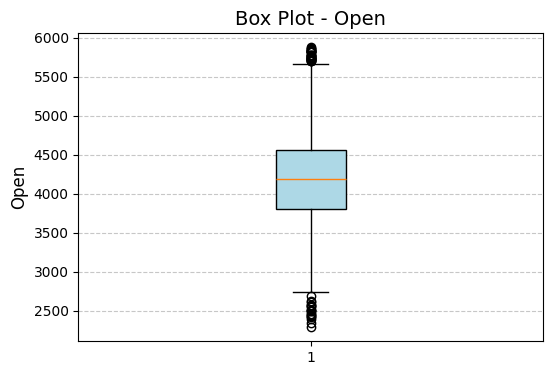

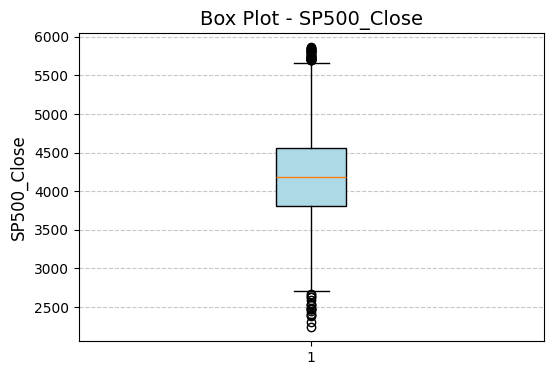

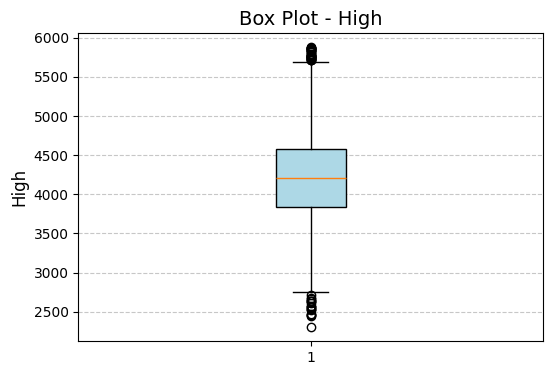

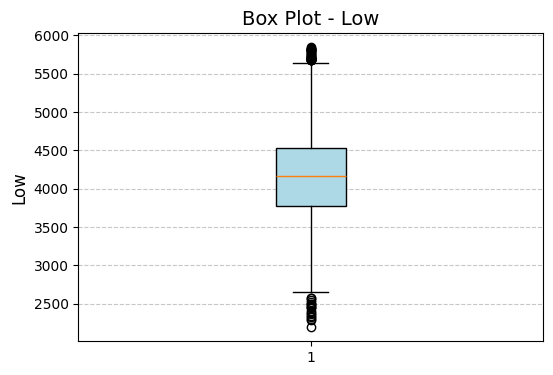

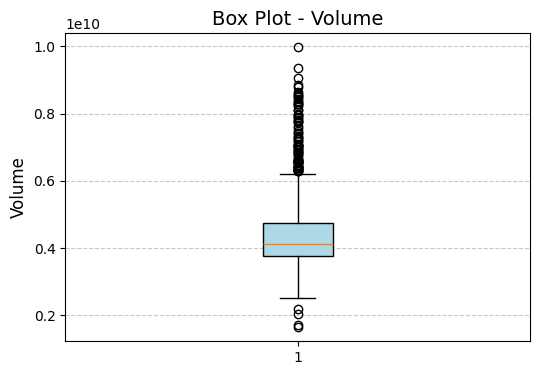

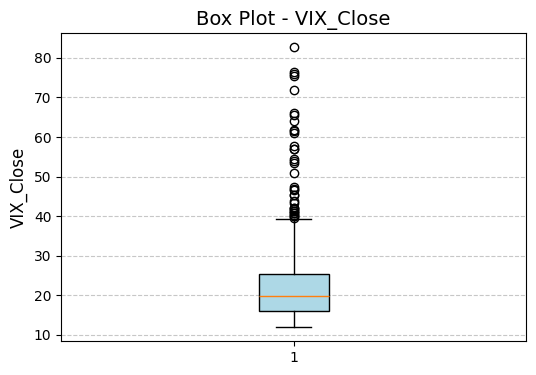

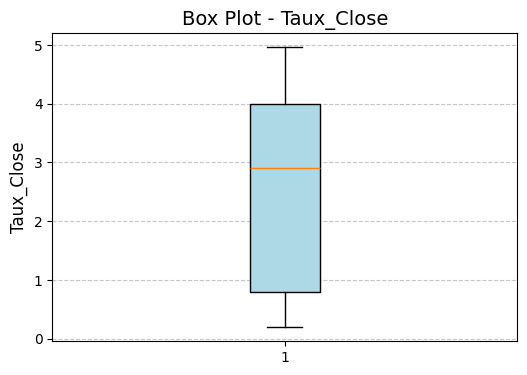

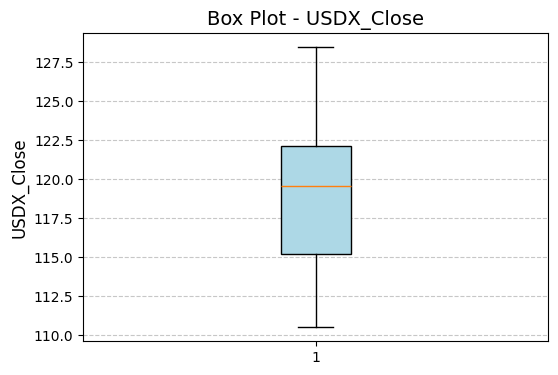

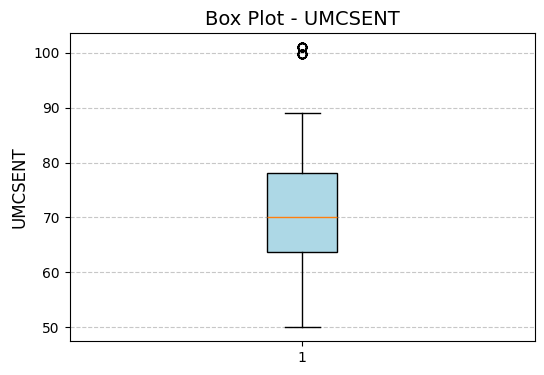

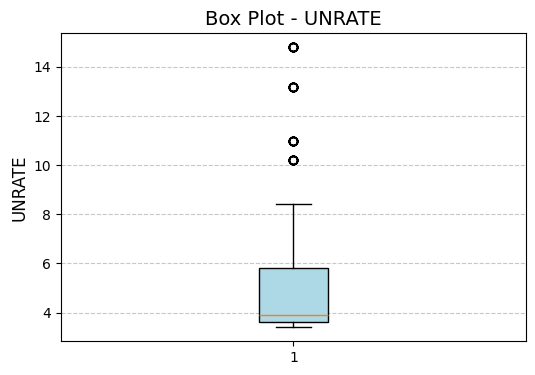

In [ ]:
import matplotlib.pyplot as plt

# Tracer un box plot pour chaque colonne
for column in merged_data.columns:
    plt.figure(figsize=(6, 4))
    plt.boxplot(merged_data[column].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(f"Box Plot - {column}", fontsize=14)
    plt.ylabel(column, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


### Analyse des valeurs aberrantes

Les valeurs aberrantes observées dans les variables macroéconomiques et l'indice S&P 500 sont dues aux bouleversements causés par la pandémie de COVID-19. Elles ne proviennent pas d'erreurs de saisie et doivent être conservées car :  

1. **Représentation des marchés extrêmes** : Elles reflètent des périodes de forte volatilité essentielles pour modéliser les marchés haussiers et baissiers.  
2. **Amélioration du modèle** : Leur inclusion renforce la capacité des modèles à prédire des scénarios de crise et à réaliser des analyses de risque.  
3. **Contexte macroéconomique pertinent** : Elles relient les chocs exogènes (COVID) aux fluctuations des marchés.  

Ces données enrichissent le modèle en offrant une meilleure robustesse face aux conditions extrêmes.


Dans la partie **"Gestion des valeurs manquantes et aberrantes"** de notre rapport, nous expliquons comment la crise COVID a occasionné ces valeurs aberrantes.

### <u>2 - Pré-traitement des données et analyse statistique de la série temporelle du S&P 500</u>

Dans cette section, nous effectuons les étapes clés du pré-traitement et de l'analyse statistique de la série temporelle du S&P 500, en mettant l'accent sur les spécificités des données temporelles :  

1. **Test de stationnarité** :  
   - Utilisation du test ADF pour évaluer si la série est stationnaire.  
   - En cas de non-stationnarité, application de transformations  log-return pour stabiliser la moyenne et la variance.  

2. **Analyse de tendance et de saisonnalité** :  
   - Décomposition de la série pour séparer la composante de tendance, la saisonnalité et les résidus.  
   - Identification d’éventuelles variations cycliques ou patterns récurrents.  


3. **Visualisation** :  
   - Tracé des séries transformées pour vérifier la pertinence des pré-traitements.  

Ces étapes permettent de transformer la série en un format exploitable tout en préservant les informations essentielles pour la modélisation prédictive.


#### --- Analyse de stationnarité ---

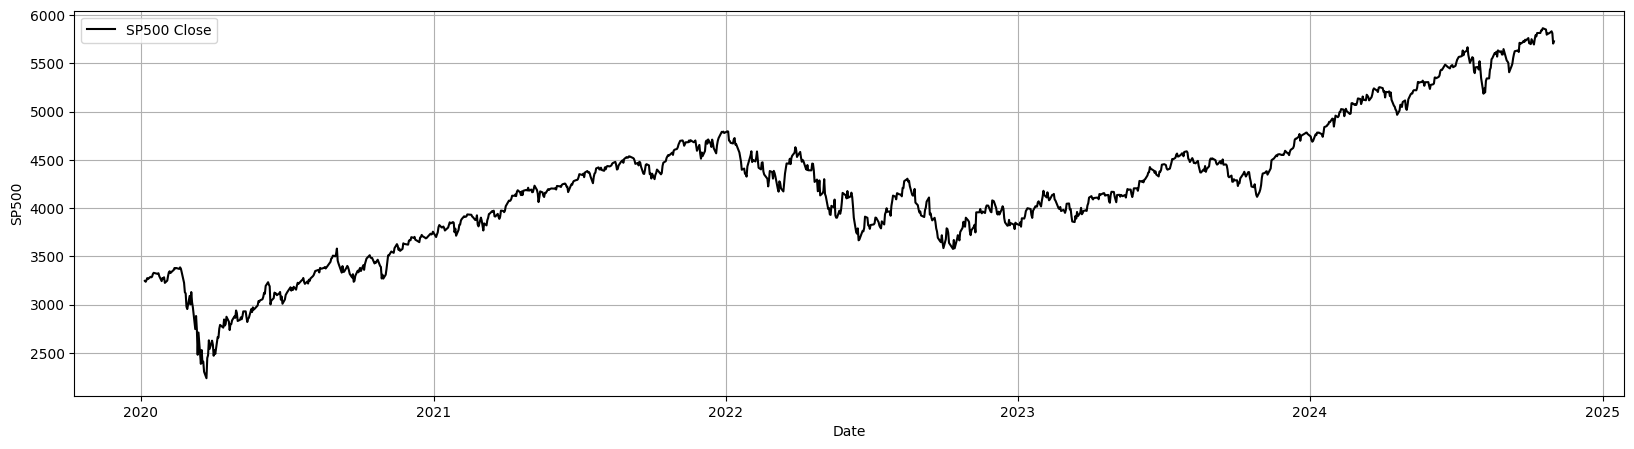

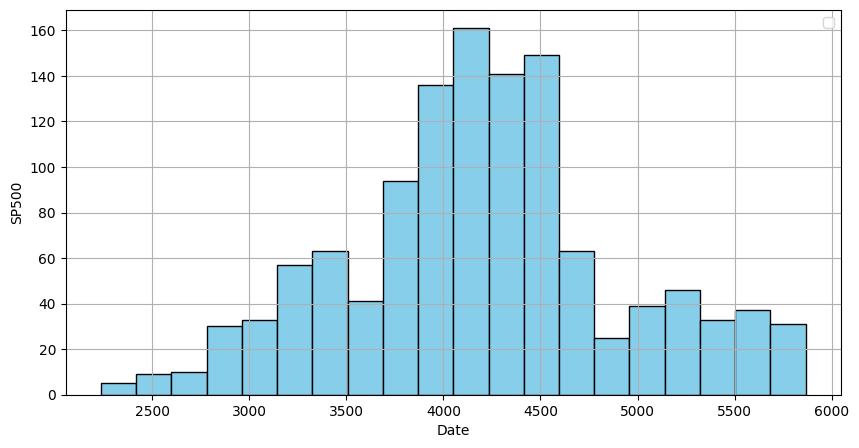

In [ ]:
# Observation de la tendance
plt.figure(figsize=(20, 5))
plt.plot(merged_data.index, merged_data['SP500_Close'], label='SP500 Close', color='black')
plt.xlabel('Date')
plt.ylabel('SP500')
plt.legend()
plt.grid(True)
plt.show()

# Observation de la tendance
plt.figure(figsize=(10, 5))
plt.hist(merged_data['SP500_Close'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('SP500')
plt.legend()
plt.grid(True)
plt.show()

Le graphique plus haut montre la présence d'une tendance haussière et d'une saisonnalité ce qui fait que la série ne peut être stationnaire. On remarque également que le cours de SP500 a une distribution proche d'une distribution normale relativement applatie.

Ces différentes observations ont motivé notre choix d'appliquer une transformation log return à notre variable SP500

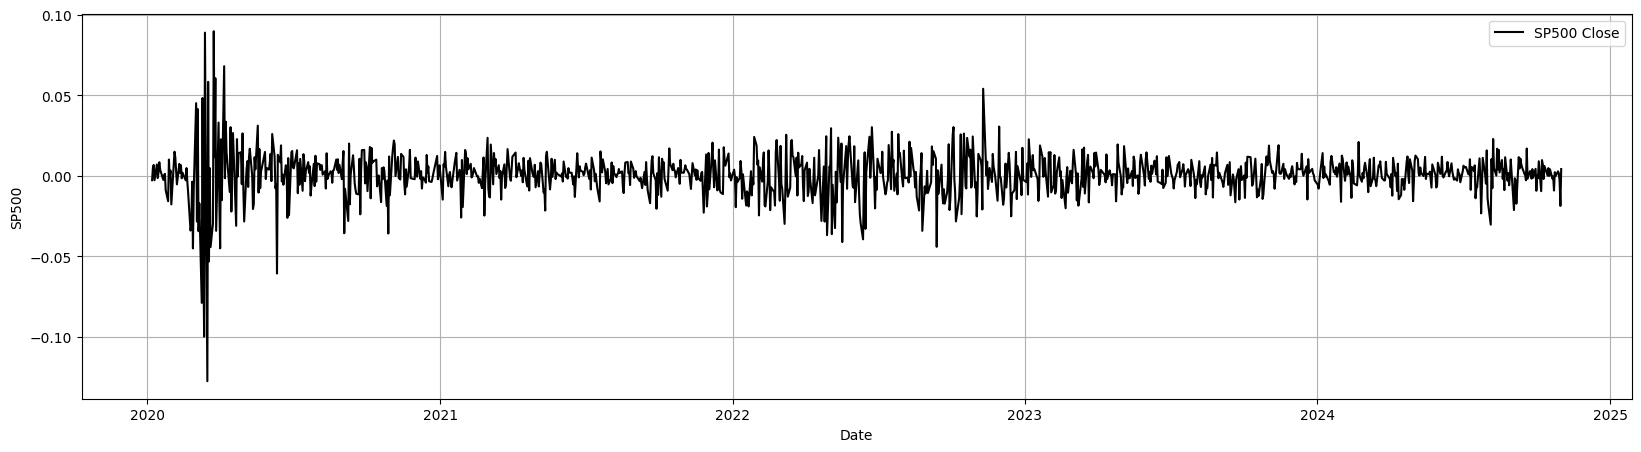

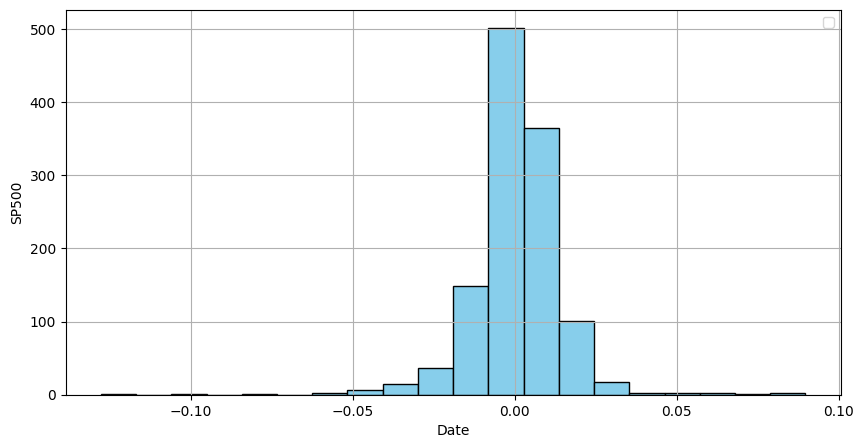

In [ ]:
# Calcul des rendements log
log_returns = np.log(merged_data['SP500_Close'] / merged_data['SP500_Close'].shift(1))

# Observation de la tendance après la tranformation log return
plt.figure(figsize=(20, 5))
plt.plot(log_returns.index, log_returns, label='SP500 Close', color='black')
plt.xlabel('Date')
plt.ylabel('SP500')
plt.legend()
plt.grid(True)
plt.show()

# Observation de la distribution après la transformation log_return
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('SP500')
plt.legend()
plt.grid(True)
plt.show()

La transformation a permis de retirer la tendance d'une part et d'autre part elle a resséré la distribution originale autour de la moyenne


Nous allons maintenant passer à l'analyse de stationnarité

---Test ADF----

Statistique ADF : -10.438079147373386
p-value : 1.5475310425970037e-18
Valeurs critiques : {'1%': -3.43584323237365, '5%': -2.863965714307509, '10%': -2.5680614958661483}
Conclusion : La série est stationnaire (p-value ≤ 0.05)


<Figure size 1000x500 with 0 Axes>

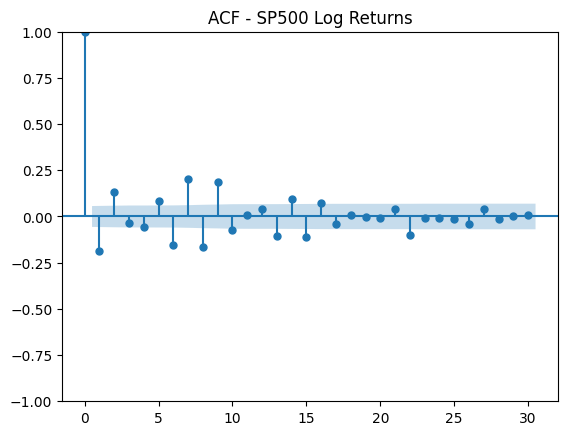

<Figure size 1000x500 with 0 Axes>

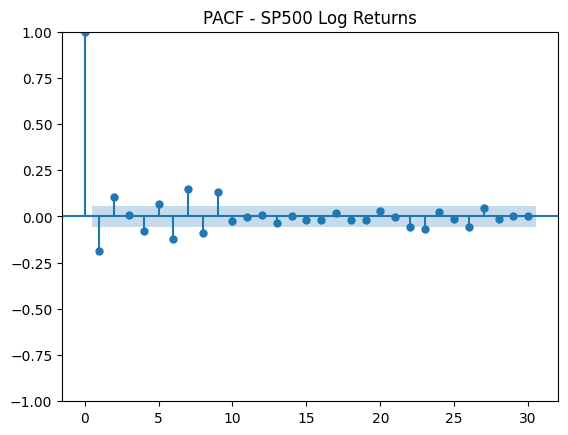

In [ ]:
# Fonction pour le test ADF
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"Statistique ADF : {result[0]}")
    print(f"p-value : {result[1]}")
    print(f"Valeurs critiques : {result[4]}")
    if result[1] <= 0.05:
        print("Conclusion : La série est stationnaire (p-value ≤ 0.05)")
    else:
        print("Conclusion : La série n'est pas stationnaire (p-value > 0.05)")

# Appliquer le test ADF
adf_test(log_returns)

# Tracer l'ACF
plt.figure(figsize=(10, 5))
plot_acf(log_returns.dropna(), lags=30)
plt.title("ACF - SP500 Log Returns")
plt.show()

# Tracer la PACF
plt.figure(figsize=(10, 5))
plot_pacf(log_returns.dropna(), lags=30, method='ywm')
plt.title("PACF - SP500 Log Returns")
plt.show()

La série des logs est stationnaire d'après le test de Adfuller. L'ACF nous donne une idée de l'odre q adéquat du MA tandis que le PACF quant à lui donne l'ordre p adéquat du AR. q = 10 semble être le à partir duquel le PACF ne dépasse pas la la limite statistiquement significative. p = 8

#### --- Décomposition des composantes de la série temporelle en tendance, saisonnalité et résidu ---

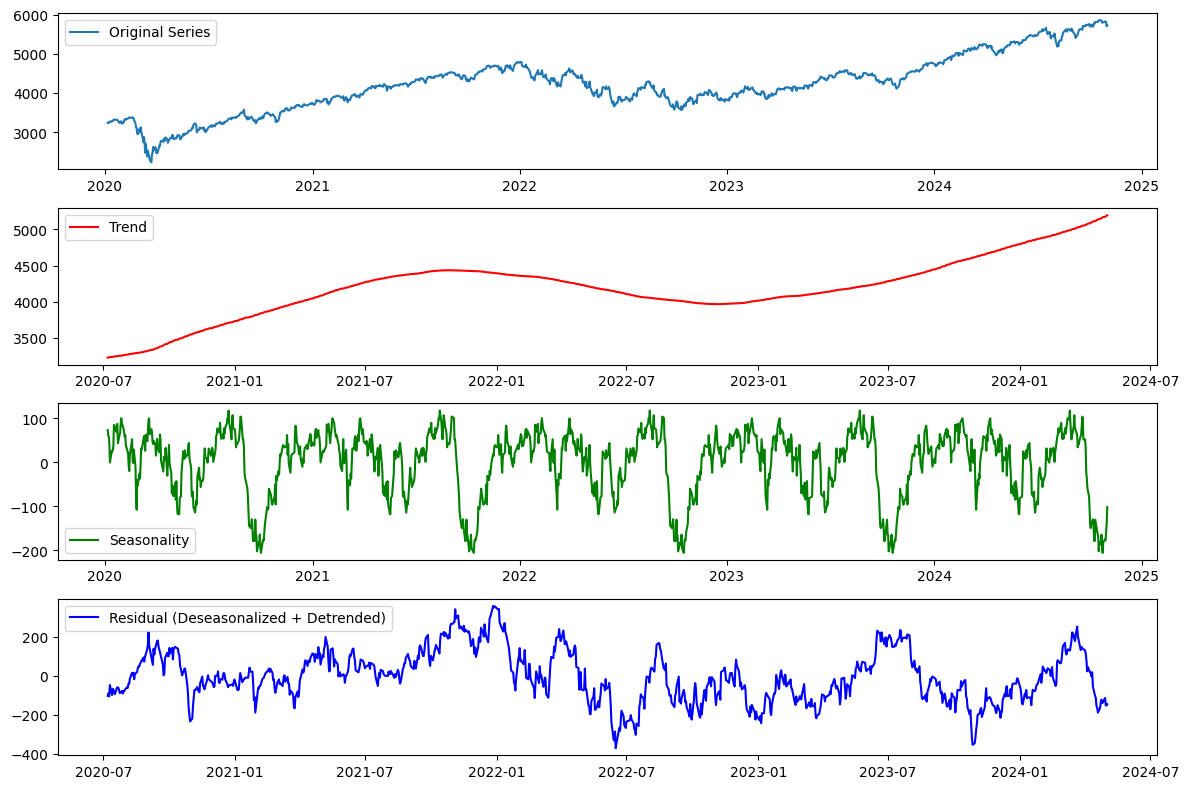

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposer la série temporelle
sp500_series = merged_data['SP500_Close'].dropna()  # Assurez-vous qu'il n'y a pas de valeurs manquantes
decomposition = seasonal_decompose(sp500_series, period=252, model='additive')  # Période saisonnière : 252 jours (1 an pour les données quotidiennes)

# Extraire les composantes
trend_component = decomposition.trend
seasonal_component = decomposition.seasonal
residual_component = decomposition.resid  # Série sans tendance ni saisonnalité

# Visualiser les composantes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(sp500_series, label='Original Series')
plt.legend()

plt.subplot(412)
plt.plot(trend_component, label='Trend', color='red')
plt.legend()

plt.subplot(413)
plt.plot(seasonal_component, label='Seasonality', color='green')
plt.legend()

plt.subplot(414)
plt.plot(residual_component, label='Residual (Deseasonalized + Detrended)', color='blue')
plt.legend()

plt.tight_layout()
plt.show()


### <u>3 - Feature engineering</u>
Nos données ayant été  collectées, nous allons procéder au calcul de quelques indicateurs techniques généralement utilisé dans le contexte de trading. Ce sont :

- Les moyennes mobiles

- Le MACD est calculé en soustrayant la moyenne mobile exponentielle (MME) à 26 périodes du prix d'un titre de la MME à 12 périodes de ce même prix. Cela permet d'éliminer tous les signaux de négociation à court terme et d'obtenir une ligne de signal de momentum à moyen terme plus stable.

- Indice de force relative (RSI)
Le RSI est un indicateur technique qui aide les traders à comprendre si une action ou un autre instrument financier est suracheté. Une valeur supérieure à un certain seuil sur le RSI est considérée comme surachetée, ce qui signifie que le prix de l'action est élevé et pourrait bientôt baisser.

#### --- Calcul des moyennes mobiles (SMA - simple ) ---

In [ ]:
merged_data['SMA_20'] = merged_data['SP500_Close'].rolling(window=20).mean()

#### --- Calcul du RSI ---

In [ ]:
def calculate_rsi(data, column, window=14):
    """
    Calculate the Relative Strength Index (RSI) for a given column in a DataFrame.

    Parameters:
    - data: DataFrame containing stock values.
    - column: The name of the column for which RSI should be calculated.
    - window: Rolling window size (default is 14).

    Returns:
    - A pandas Series containing the RSI values.
    """
    # Calculate the change between consecutive prices
    close_delta = data[column].diff()

    # Separate positive and negative changes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    # Calculate the exponential moving average (EMA) of gains and losses
    ma_up = up.ewm(com=window - 1, adjust=True, min_periods=window).mean()
    ma_down = down.ewm(com=window - 1, adjust=True, min_periods=window).mean()

    # Calculate the Relative Strength (RS) and RSI
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))

    return rsi

merged_data['RSI_14'] = calculate_rsi(merged_data, column = 'SP500_Close', window=14)

#### --- Calcul du MACD ---

In [ ]:
merged_data['EMA_12'] = merged_data['SP500_Close'].ewm(span=12, adjust=False).mean()
merged_data['EMA_26'] = merged_data['SP500_Close'].ewm(span=26, adjust=False).mean()
merged_data['MACD'] = merged_data['EMA_12'] - merged_data['EMA_26']
merged_data['Signal_Line'] = merged_data['MACD'].ewm(span=9, adjust=False).mean()
merged_data.drop(columns=['EMA_12', 'EMA_26'], inplace=True)

#### --- Visualisation des indicateurs techniques ---

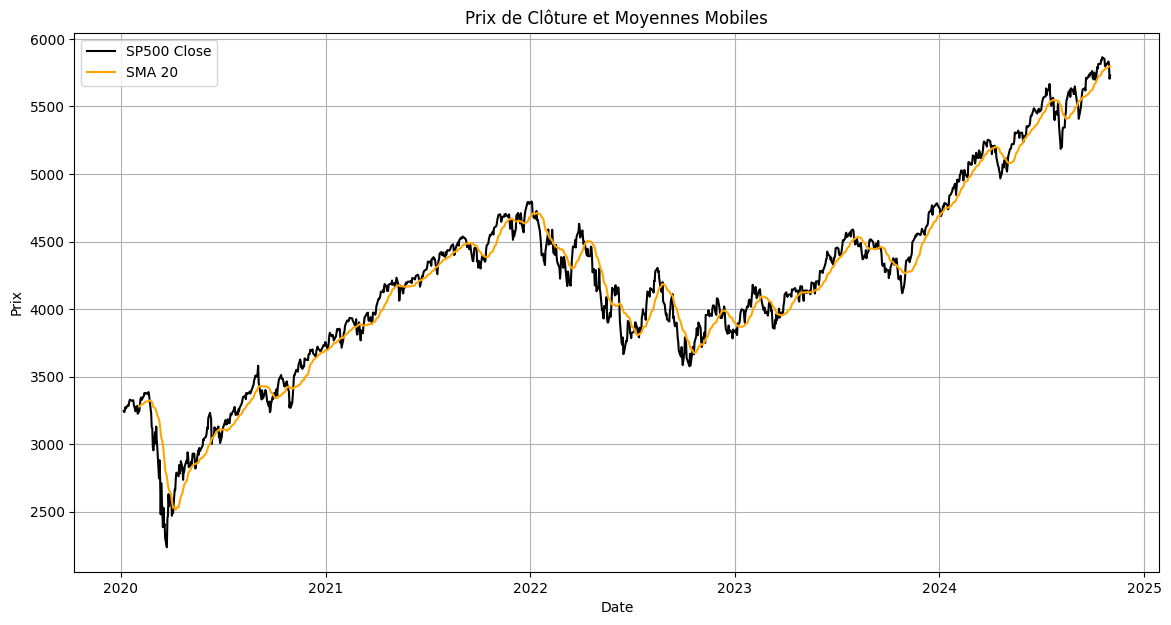

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['SP500_Close'], label='SP500 Close', color='black')
plt.plot(merged_data.index, merged_data['SMA_20'], label='SMA 20', color='orange')
plt.title('Prix de Clôture et Moyennes Mobiles')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.grid(True)
plt.show()

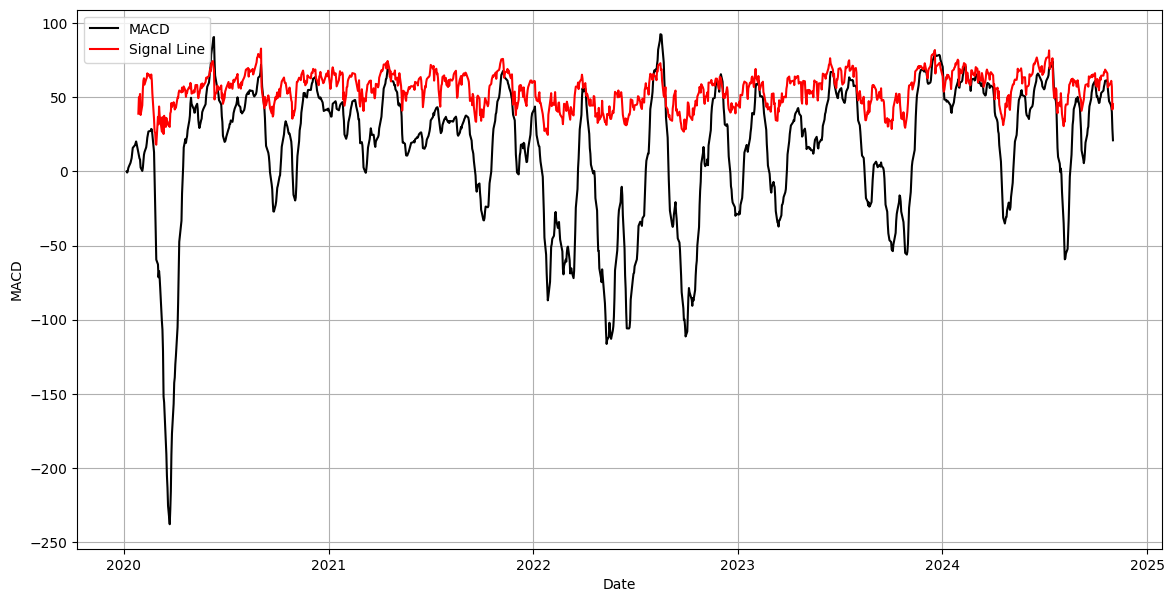

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['MACD'], label='MACD', color='black')
plt.plot(merged_data.index, merged_data['RSI_14'], label='Signal Line', color='red')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
merged_data.dropna(inplace = True)
merged_data.isna().sum()

,0
Open,0
SP500_Close,0
High,0
Low,0
Volume,0
VIX_Close,0
Taux_Close,0
USDX_Close,0
UMCSENT,0
UNRATE,0


#### --- Analyse de la corrélation ---

Avant de tracer la matrice de corrélation, nous allons nous interesser à la corrélation entre notre variable target (SP500) et les autres features affectées d'un shift. Notre objectif étant de déterminer un lag optimal qui optimize la corrélation afin que celui ci puisse être utilisé comme horizon de prédiction.

In [ ]:
def find_best_shift(merged_data, sp500_col, vix_col, min_shift, max_shift):
    correlations = {}
    for shift in range(min_shift,max_shift + 1):
        # Shift de la colonne VIX_Close
        merged_data[f'{vix_col}_shifted'] = merged_data[vix_col].shift(shift)

        # Calcul de correlation, dropping NaN values
        corr = merged_data[[sp500_col, f'{vix_col}_shifted']].corr().iloc[0, 1]
        correlations[shift] = corr

    # Recherche du shift avec la corrélation la plus élevée
    best_shift = max(correlations, key=lambda k: abs(correlations[k]))

    return best_shift, correlations[best_shift]

best_shift_1, best_correlation_1 = find_best_shift(merged_data, 'SP500_Close', 'VIX_Close', min_shift = 1, max_shift=10) # On choisit exprès un intervalle centré en 30 qui est la matu des options utilisées pour calculer VIX
print(f"Best shift: {best_shift_1}, Correlation: {best_correlation_1}")

best_shift_2, best_correlation_2 = find_best_shift(merged_data, 'SP500_Close', 'Taux_Close', min_shift = 1, max_shift=10)
print(f"Best shift: {best_shift_2}, Correlation: {best_correlation_2}")

best_shift_3, best_correlation_3 = find_best_shift(merged_data, 'SP500_Close', 'USDX_Close', min_shift = 1, max_shift=10)
print(f"Best shift: {best_shift_3}, Correlation: {best_correlation_3}")

best_shift_4, best_correlation_4 = find_best_shift(merged_data, 'SP500_Close', 'UMCSENT', min_shift = 1, max_shift=5)
print(f"Best shift: {best_shift_4}, Correlation: {best_correlation_4}")

best_shift_5, best_correlation_5 = find_best_shift(merged_data, 'SP500_Close', 'UNRATE', min_shift = 1, max_shift=10)
print(f"Best shift: {best_shift_5}, Correlation: {best_correlation_5}")

best_shift_6, best_correlation_6 = find_best_shift(merged_data, 'SP500_Close', 'SMA_20', min_shift = 1, max_shift=10)
print(f"Best shift: {best_shift_6}, Correlation: {best_correlation_6}")

best_shift_7, best_correlation_7 = find_best_shift(merged_data, 'SP500_Close', 'RSI_14', min_shift = 1, max_shift=10)
print(f"Best shift: {best_shift_7}, Correlation: {best_correlation_7}")

best_shift_8, best_correlation_8 = find_best_shift(merged_data, 'SP500_Close', 'MACD', min_shift = 1, max_shift=10)
print(f"Best shift: {best_shift_8}, Correlation: {best_correlation_8}")

Best shift: 2, Correlation: -0.6899346986428485
Best shift: 1, Correlation: 0.5875954751395344
Best shift: 1, Correlation: 0.15179486125422284
Best shift: 5, Correlation: -0.19034568173567357
Best shift: 1, Correlation: -0.5693539111539123
Best shift: 1, Correlation: 0.9850952254358226
Best shift: 2, Correlation: 0.2582999279143123
Best shift: 1, Correlation: 0.32471427954193305


Ainsi après avoir tester plusieurs lags, nous avons décider de poursuivre avec le lag 2. Ce lag laisse du temps à l'investisseur pour mettre en place ses stratégies d'une part et d'autre part il permet de prendre en compte le momentum du marché ( l'élan du marché )

#### --- Matrice de corrélation ---


In [ ]:
merged_data['VIX_Close_shift_2'] = merged_data['VIX_Close'].shift(2)
merged_data['Taux_Close_shift_2'] = merged_data['Taux_Close'].shift(2)
merged_data['USDX_Close_shift_2'] = merged_data['USDX_Close'].shift(2)
merged_data['UMCSENT_shift_2'] = merged_data['UMCSENT'].shift(2)
merged_data['UNRATE_shift_2'] = merged_data['UNRATE'].shift(2)
merged_data['SMA_20_shift_2'] = merged_data['SMA_20'].shift(2)
merged_data['RSI_14_shift_2'] = merged_data['RSI_14'].shift(2)
merged_data['MACD_shift_2'] = merged_data['MACD'].shift(2)
merged_data['SP500_Close_shift_2'] = merged_data['SP500_Close'].shift(2)
merged_data['High_shift_1'] = merged_data['High'].shift(1)
merged_data['Low_shift_1'] = merged_data['Low'].shift(1)
merged_data['Open_shift_1'] = merged_data['Open'].shift(1)
merged_data['close_shift_1'] = merged_data['SP500_Close'].shift(1)
merged_data['Volume_shift_1'] = merged_data['Volume'].shift(1)

In [ ]:
merged_data

,Open,SP500_Close,High,Low,Volume,VIX_Close,Taux_Close,USDX_Close,UMCSENT,UNRATE,...,UNRATE_shift_2,SMA_20_shift_2,RSI_14_shift_2,MACD_shift_2,SP500_Close_shift_2,High_shift_1,Low_shift_1,Open_shift_1,close_shift_1,Volume_shift_1
2020-02-03,3235.659912,3248.919922,3268.439941,3235.659912,3.760460e+09,17.969999,1.343,116.1176,101.0,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,3280.610107,3297.590088,3306.919922,3280.610107,3.996900e+09,16.049999,1.424,115.9290,101.0,3.5,...,NaN,NaN,NaN,NaN,NaN,3268.439941,3235.659912,3235.659912,3248.919922,3.760460e+09
2020-02-05,3324.909912,3334.689941,3337.580078,3313.750000,4.121480e+09,15.150000,1.460,116.0082,101.0,3.5,...,3.5,3279.923987,44.616352,0.338037,3248.919922,3306.919922,3280.610107,3280.610107,3297.590088,3.996900e+09
2020-02-06,3344.919922,3345.780029,3347.959961,3334.389893,3.887250e+09,14.960000,1.460,116.1508,101.0,3.5,...,3.5,3282.489490,55.175353,2.369471,3297.590088,3337.580078,3313.750000,3324.909912,3334.689941,4.121480e+09
2020-02-07,3335.540039,3327.709961,3341.419922,3322.120117,3.733920e+09,15.470000,1.401,116.5075,101.0,3.5,...,3.5,3287.364990,61.241372,6.893580,3334.689941,3347.959961,3334.389893,3344.919922,3345.780029,3.887250e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,5833.930176,5823.520020,5842.919922,5823.080078,3.691280e+09,19.799999,4.108,125.0385,70.5,4.1,...,4.1,5781.291968,58.298802,51.270909,5809.859863,5862.819824,5799.979980,5826.750000,5808.120117,3.501280e+09
2024-10-29,5819.680176,5832.919922,5847.189941,5802.169922,3.879100e+09,19.340000,4.104,125.0952,70.5,4.1,...,4.1,5784.429468,58.000386,47.435599,5808.120117,5842.919922,5823.080078,5833.930176,5823.520020,3.691280e+09
2024-10-30,5832.649902,5813.669922,5850.939941,5811.279785,3.851120e+09,20.350000,4.127,125.0444,70.5,4.1,...,4.1,5788.696973,59.954424,45.118632,5823.520020,5847.189941,5802.169922,5819.680176,5832.919922,3.879100e+09
2024-10-31,5775.339844,5705.450195,5775.339844,5702.859863,4.425660e+09,23.160000,4.155,125.0247,70.5,4.1,...,4.1,5792.218970,61.142788,43.539022,5832.919922,5850.939941,5811.279785,5832.649902,5813.669922,3.851120e+09


In [ ]:
features = ['Open', 'High_shift_1', 'Low_shift_1','Volume_shift_1','Open_shift_1','close_shift_1','SP500_Close','VIX_Close_shift_2',
            'Taux_Close_shift_2','USDX_Close_shift_2','UMCSENT_shift_2','UNRATE_shift_2','SMA_20_shift_2','RSI_14_shift_2','MACD_shift_2','SP500_Close_shift_2']
lag_merged_data = merged_data[features]
lag_merged_data.dropna(inplace = True)

<ipython-input-21-697f4d183195>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lag_merged_data.dropna(inplace = True)


In [ ]:
lag_merged_data

,Open,High_shift_1,Low_shift_1,Volume_shift_1,Open_shift_1,close_shift_1,SP500_Close,VIX_Close_shift_2,Taux_Close_shift_2,USDX_Close_shift_2,UMCSENT_shift_2,UNRATE_shift_2,SMA_20_shift_2,RSI_14_shift_2,MACD_shift_2,SP500_Close_shift_2
2020-02-05,3324.909912,3306.919922,3280.610107,3.996900e+09,3280.610107,3297.590088,3334.689941,17.969999,1.343,116.1176,101.0,3.5,3279.923987,44.616352,0.338037,3248.919922
2020-02-06,3344.919922,3337.580078,3313.750000,4.121480e+09,3324.909912,3334.689941,3345.780029,16.049999,1.424,115.9290,101.0,3.5,3282.489490,55.175353,2.369471,3297.590088
2020-02-07,3335.540039,3347.959961,3334.389893,3.887250e+09,3344.919922,3345.780029,3327.709961,15.150000,1.460,116.0082,101.0,3.5,3287.364990,61.241372,6.893580,3334.689941
2020-02-10,3318.280029,3341.419922,3322.120117,3.733920e+09,3335.540039,3327.709961,3352.090088,14.960000,1.460,116.1508,101.0,3.5,3292.001489,62.859390,11.244230,3345.780029
2020-02-11,3365.870117,3352.260010,3317.770020,3.462730e+09,3318.280029,3352.090088,3357.750000,15.470000,1.401,116.5075,101.0,3.5,3294.651990,58.569041,13.083233,3327.709961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,5833.930176,5862.819824,5799.979980,3.501280e+09,5826.750000,5808.120117,5823.520020,19.080000,4.019,124.7430,70.5,4.1,5781.291968,58.298802,51.270909,5809.859863
2024-10-29,5819.680176,5842.919922,5823.080078,3.691280e+09,5833.930176,5823.520020,5832.919922,20.330000,4.051,124.8418,70.5,4.1,5784.429468,58.000386,47.435599,5808.120117
2024-10-30,5832.649902,5847.189941,5802.169922,3.879100e+09,5819.680176,5832.919922,5813.669922,19.799999,4.108,125.0385,70.5,4.1,5788.696973,59.954424,45.118632,5823.520020
2024-10-31,5775.339844,5850.939941,5811.279785,3.851120e+09,5832.649902,5813.669922,5705.450195,19.340000,4.104,125.0952,70.5,4.1,5792.218970,61.142788,43.539022,5832.919922


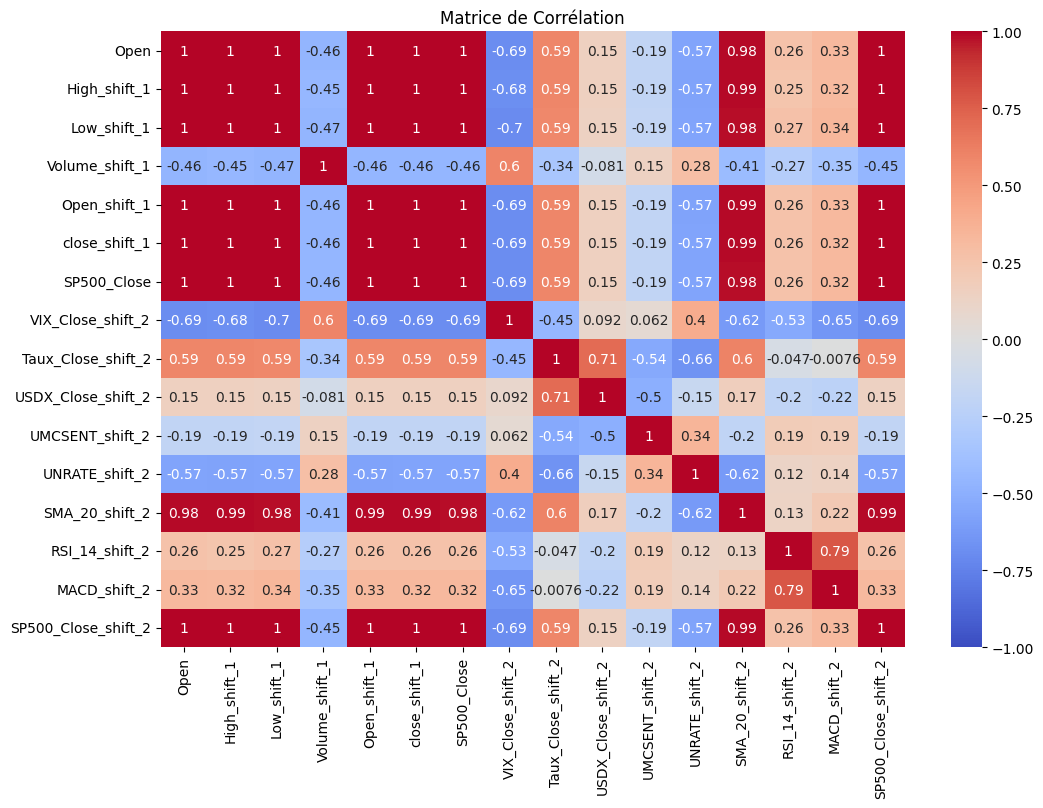

In [ ]:
correlation_matrix = lag_merged_data.corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()

<h1 style='color: blue;'>Partie 2 : Développement du modèle prédictif</h1>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### <u>1 - Choix des modèles</u>

#### --- Implémentation régression linéaire ---

### <u>3 - Modélisation : Régression linéaire</u>

Nous allons entraîner un modèle de régression linéaire en utilisant les variables explicatives suivante : Open, 'High', 'Low','Volume_shift','Open_shift','close_shift','SP500_Close','VIX_Close_lag2','Taux_Close_lag2','USDX_Close_lag2','UMCSENT_lag2','UNRATE_lag2','SMA_20_lag2','RSI_14_lag2','MACD_lag2.

Une première remarque est que toutes les variables explicatives considérées sont affectées d'un shift (décalage temporelle d'au moins un jour) à l'exception de la variable 'Open' qui est le prix du SP500 à l'ouverture.
Le décalage est nécessaire car l'objectif est de prédire le futur.
Le fait d'inclure la variable 'Open' dans les features implique que l'on fait la prédiction du prix close(la soir) au matin.

#### **Métriques d'évaluation** :
1. **Problème de régression** :  
   - **RMSE** et **MAE** sont utilisées pour évaluer la précision des prédictions en termes de valeur continue.
   - R2 afin de savoir à quel point notre prédiction est correlée aux vraies valeurs
   l'avantage du R2 par rapport aux 2 autres métriques est que cette métrique ne dépend pas de l'odre de grandeur de la variable prédite.
   En effet un MAE de 10 quand on prédit des données de l'ordre de millier est un super résultat alors que s'il l'on prédit des données de l'odre de dizaine c'est un peu moins bien.

Aussi, on aimerait standardiser les données afin de pouvoir comparer la significativité des poids du modèle entre eux et juger de la pertinence des variables les unes par rapport aux autres


2. **Problème de classification binaire** :  
   - Nous évaluons également la capacité du modèle à prédire correctement la direction (hausse ou baisse) du cours du S&P 500.  
   - La métrique **accuracy** est calculée pour mesurer la proportion de prédictions correctes des mouvements du marché.  

#### **Méthodologie pour la classification binaire** :
- À chaque horizon, nous comparons :  
  - La valeur prédite par le modèle et la valeur à l'ouverture.   
  - Si la différence est positive, le modèle prédit une hausse, sinon une baisse.  Tandis que le réel mouvement observé est obtenu en comparant le prix réel close et le prix à l'ouverture.
- La comparaison entre ces prédictions et les vrais mouvements du marché permet de déterminer l’accuracy.

Cette double évaluation (régression et classification) permet de mesurer la performance du modèle dans les deux contextes et d’explorer son utilité pour différentes applications.



In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Define X and y
y = lag_merged_data['SP500_Close']
X = lag_merged_data.drop(columns=['SP500_Close'])

# Standardiser les données
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Définir les données standardisées comme nouvelles entrées
X = X_standardized

# Initialiser TimeSeriesSplit avec 15 splits
tscv = TimeSeriesSplit(n_splits=15)

# Variables pour stocker les erreurs et métriques
train_rmse = []
rmse_list = []
mae_list = []
accuracy_list = []

# Boucle pour effectuer la validation croisée
for train_index, test_index in tscv.split(X):
    # Diviser les données en training et testing
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialiser et entraîner le modèle linéaire
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcul des erreurs
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)

    # Calcul de l'accuracy pour la direction (hausse/baisse)
    y_direction = np.sign(y_test-X_test['Open'])
    y_pred_direction = np.sign(y_test_pred - X_test['Open']).fillna(0)
    accuracy = accuracy_score(y_direction, y_pred_direction)


    # Stockage des résultats
    mae_list.append(mae)
    rmse_list.append(rmse)
    accuracy_list.append(accuracy)

# Créer un DataFrame pour les résidus
residuals = y_test - y_test_pred
residuals_df = pd.DataFrame({'Predicted': y_test_pred, 'Residuals': residuals})
#evaluate model's performance on test data
r2 = r2_score(y_test, y_test_pred)


# Afficher les coefficients standardisés pour juger de la pertinence des variables
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_}).sort_values(by='Coefficient', ascending=False)
print(coefficients)
# Affichage des résultats moyens
print("Régression linéaire - résultats :")
print(f"Moyenne MAE : {np.mean(mae_list)}")
print(f"Moyenne RMSE : {np.mean(rmse_list)}")
print(f"Moyenne Accuracy : {np.mean(accuracy_list)}")
print("R2 Score:", r2)

               Variable  Coefficient
0                  Open   992.162220
2           Low_shift_1    97.912521
1          High_shift_1    83.728202
14  SP500_Close_shift_2    17.691012
3        Volume_shift_1     2.095901
8    USDX_Close_shift_2     1.002446
12       RSI_14_shift_2     0.829567
9       UMCSENT_shift_2    -0.199756
10       UNRATE_shift_2    -1.377103
7    Taux_Close_shift_2    -1.411194
11       SMA_20_shift_2    -2.847642
13         MACD_shift_2    -3.750364
6     VIX_Close_shift_2    -3.924503
4          Open_shift_1   -75.428956
5         close_shift_1  -407.018735
Régression linéaire - résultats :
Moyenne MAE : 32.04909189231561
Moyenne RMSE : 39.5469302133671
Moyenne Accuracy : 1.0
R2 Score: 0.9459135291801428


Il ressort que les variables les plus importantes sont donc : le prix à l'ouverture au jour ou l'on prédit, le prix low et le prix high du jour avant, le volume du jour avant, le VIX deux jours avant, le prix à l'ouverture du jour avant, le prix close é jours avant et le prix close du jour avant.
Nous allons donc maintenant passer à l'entrainement du modèle avec que ces variables.

In [ ]:
features_selected = ['Open','Open_shift_1','Low_shift_1','High_shift_1','Volume_shift_1','VIX_Close_shift_2','close_shift_1','SP500_Close','SP500_Close_shift_2']
lag_merged_data_ = lag_merged_data[features_selected]

In [ ]:

y = lag_merged_data_['SP500_Close']
X = lag_merged_data_.drop(columns=['SP500_Close'])

# Standardiser les données
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Définir les données standardisées comme nouvelles entrées
X = X_standardized

# Initialize TimeSeriesSplit with 10 splits
tscv = TimeSeriesSplit(n_splits=10)

# Variables to store errors and metrics
train_rmse = []
rmse_list = []
mae_list = []
accuracy_list = []
r2_list = []
# Loop over splits for cross-validation
for train_index, test_index in tscv.split(X):
    # Split data into training and testing
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # RMSE calculation
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)

    # Calcul de l'accuracy pour la direction (hausse/baisse)
    y_direction = np.sign(y_test-X_test['Open'])
    y_pred_direction = np.sign(y_test_pred - X_test['Open'])
    accuracy = accuracy_score(y_direction, y_pred_direction)

    # Stockage des résultats
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2_score(y_test, y_test_pred))
    accuracy_list.append(accuracy)


# Create DataFrame for residuals
residuals = y_test - y_test_pred
residuals_df = pd.DataFrame({'Predicted': y_test_pred, 'Residuals': residuals})




# Affichage des résultats moyens
print("Régression linéaire - résultats :")
print(f"Moyenne MAE : {np.mean(mae_list)}")
print(f"Moyenne RMSE : {np.mean(rmse_list)}")
print(f"Moyenne Accuracy : {np.mean(accuracy_list)}")
print(f"Moyenne R2 : {np.mean(r2_list)}")


Régression linéaire - résultats :
Moyenne MAE : 28.457064608548308
Moyenne RMSE : 36.09102459928997
Moyenne Accuracy : 1.0
Moyenne R2 : 0.9436327288575524


La réduction des features uniquement aux features pertinentes permet de gagner 4 unités sur le MAE et 3 sur le RMSE.l'univers de feature réduit présente des avantages significatifs : un modèle plus simple, rapide à entraîner, et plus interprétable. Par conséquent, il est préférable d’opter pour l’univers réduit.

Nous allons maintenant passer au tracé du nuage des résidus en fonction de prédiction. En effet, les erreurs d'un modèle linéaire parfait sont Gaussien. Ainsi plus la distribution des erreurs se rapproche d'une distribution Gaussienne, mieux l'apprentissage linéaire a été. Un nuage uniformément éparpillé est signe d'une bonne modélisation linéaire.

In [ ]:
precision = precision_score(y_direction, y_pred_direction)
recall = recall_score(y_direction, y_pred_direction)
f1 = f1_score(y_direction, y_pred_direction)
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Accuracy : 1.0000
Precision : 1.0000
Recall : 1.0000
F1 Score : 1.0000


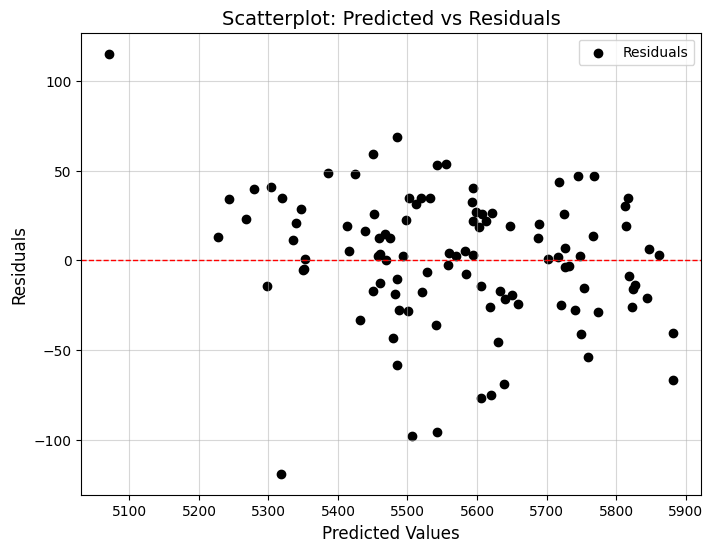

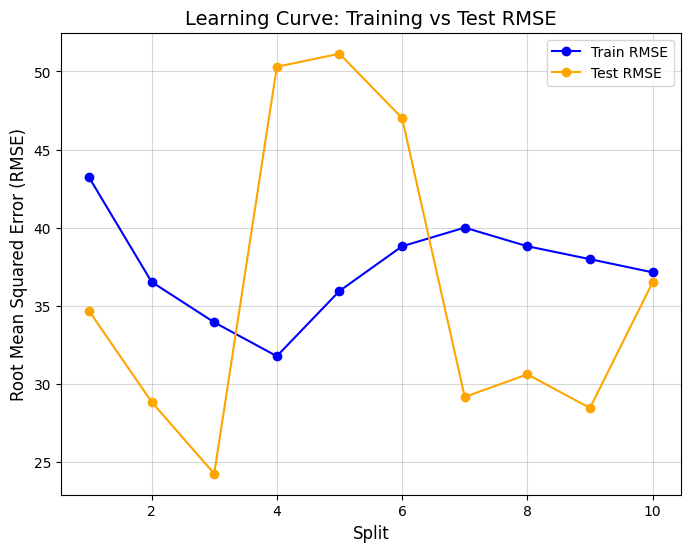

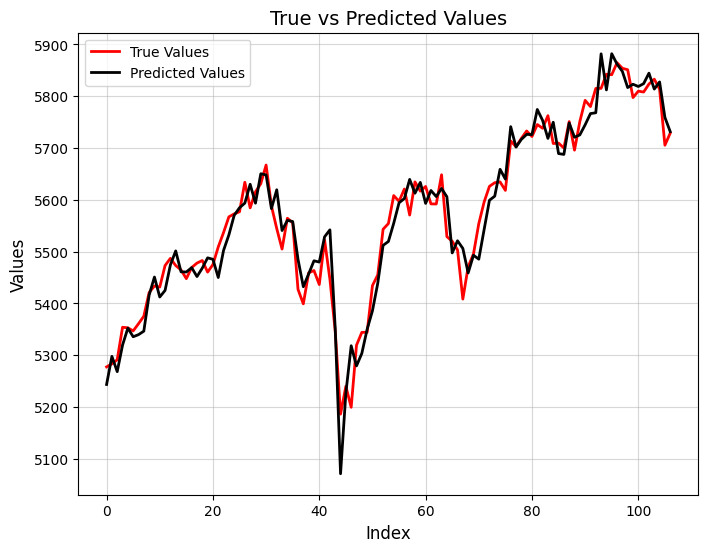

In [ ]:
# Scatterplot: Predicted vs Residuals
plt.figure(figsize=(8, 6))
plt.scatter(residuals_df['Predicted'], residuals_df['Residuals'], label='Residuals', color='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Scatterplot: Predicted vs Residuals', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# Plot RMSE learning curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, marker='o', label='Train RMSE', color='blue')
plt.plot(range(1, len(rmse_list) + 1), rmse_list, marker='o', label='Test RMSE', color='orange')
plt.title('Learning Curve: Training vs Test RMSE', fontsize=14)
plt.xlabel('Split', fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Tracer les valeurs prédites et les valeurs vraies
plt.figure(figsize=(8, 6))
plt.plot(range(len(y_test)), y_test, label='True Values', color='red', linewidth=2)
plt.plot(range(len(y_test_pred)), y_test_pred, label='Predicted Values', color='black', linewidth=2)
plt.title('True vs Predicted Values', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()




### <u>- Conclusion Regression linéaire </u>

Les résidus sont relativement éparpillés ce qui est laisse entendre que la régression linéaire semble être un modèle pertinent compte tenu des variables considérées pour la modélisation du prix close.

Le courbe d'évolution du RMSE sur les données d'entrainement fluctue peu au fil de l'évolution des données d'entrainement. Tandis que celle sur les données de test fluctue beaucoup autour la courbe sur les données d'entrainement. Ainsi le modèle apprend bien mais il a du mal à se généraliser.

Le tracé des valeurs prédictes et des vraies valeurs montrent que celles ci sont bien correlées. Ce qui est un plus pour le modèle.

#### --- Implémentation Random forest ---

Nous allons commencer par faire une recherche de feature pour le random forest regressor sur l'univers de variable initiale du linear regression. Ensuite nous allons faire une optimization des différents hyperparamètres du random forest regressor sur un univers de variables réduits avant de construire le modèle finale et de l'évaluer.

Feature extraction

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
# Define X and y
y = lag_merged_data['SP500_Close']
X = lag_merged_data.drop(columns=['SP500_Close'])
# Initialisation des variables
rmse_list, mae_list, selected_features_list = [], [], []

# Initialisation de TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Pipeline combinant standardisation et sélection des features avec un modèle RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', SelectFromModel(rf_model, threshold="median")),
    ('regressor', rf_model)
])

# Feature Selection & Cross-validation
for train_index, test_index in tscv.split(X):
    # Diviser les données en train et test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entraîner le modèle avec le pipeline
    pipeline.fit(X_train, y_train)

    # Sélection des features importantes
    selected_features = X.columns[pipeline.named_steps['feature_selector'].get_support()]
    selected_features_list.append(selected_features)

    # Prédictions
    y_test_pred = pipeline.predict(X_test)

    # Calcul des métriques
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    mae_list.append(mean_absolute_error(y_test, y_test_pred))

# Résumé des features sélectionnées
print("Features sélectionnées à chaque split :")
for i, features in enumerate(selected_features_list):
    print(f"Split {i+1}: {list(features)}")

# Résumé des métriques
metrics_df = pd.DataFrame({
    'Split': range(1, len(rmse_list) + 1),
    'Test RMSE': rmse_list,
    'MAE': mae_list
})
print(metrics_df)


Features sélectionnées à chaque split :
Split 1: ['Open', 'High_shift_1', 'Low_shift_1', 'Open_shift_1', 'close_shift_1', 'VIX_Close_shift_2', 'MACD_shift_2', 'SP500_Close_shift_2']
Split 2: ['Open', 'High_shift_1', 'Low_shift_1', 'Open_shift_1', 'close_shift_1', 'SMA_20_shift_2', 'MACD_shift_2', 'SP500_Close_shift_2']
Split 3: ['Open', 'High_shift_1', 'Low_shift_1', 'Open_shift_1', 'close_shift_1', 'VIX_Close_shift_2', 'SMA_20_shift_2', 'MACD_shift_2']
Split 4: ['Open', 'High_shift_1', 'Low_shift_1', 'Open_shift_1', 'close_shift_1', 'VIX_Close_shift_2', 'SMA_20_shift_2', 'MACD_shift_2']
Split 5: ['Open', 'High_shift_1', 'Low_shift_1', 'Open_shift_1', 'close_shift_1', 'VIX_Close_shift_2', 'MACD_shift_2', 'SP500_Close_shift_2']
   Split   Test RMSE         MAE
0      1  542.200647  471.919558
1      2  103.425833   82.048618
2      3   46.351929   37.419342
3      4   31.719860   24.725617
4      5  627.717797  565.229104


Nous passons finalement d'un univers de 16 variables à un univers de 9 variables que sont : le prix à l'ouverture, les prix high et low de la veille, les prix d'ouverture et de close de la veille, le VIX, le moyenne mobile, le MACD et prix close 2 jours avant.

In [ ]:
feature_selected__ = ['SP500_Close','Open', 'High_shift_1', 'Low_shift_1', 'Open_shift_1', 'close_shift_1', 'VIX_Close_shift_2', 'MACD_shift_2', 'SP500_Close_shift_2','SMA_20_shift_2']
lag_merged_data__ = lag_merged_data[feature_selected__]

Recherche d'hyperparamètres optimaux

In [ ]:
'''from sklearn.model_selection import GridSearchCV

param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [5, 10, 15],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=make_pipeline(StandardScaler(), RandomForestRegressor()),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X, y)
print("Best Parameters:", grid_search.best_params_)'''


'from sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    \'randomforestregressor__n_estimators\': [100, 200, 300],\n    \'randomforestregressor__max_depth\': [5, 10, 15],\n    \'randomforestregressor__min_samples_split\': [2, 5, 10],\n    \'randomforestregressor__min_samples_leaf\': [1, 2, 4],\n    \'randomforestregressor__max_features\': [\'sqrt\', \'log2\']\n}\n\ngrid_search = GridSearchCV(\n    estimator=make_pipeline(StandardScaler(), RandomForestRegressor()),\n    param_grid=param_grid,\n    cv=tscv,\n    scoring=\'neg_mean_squared_error\',\n    n_jobs=-1\n)\ngrid_search.fit(X, y)\nprint("Best Parameters:", grid_search.best_params_)'

In [ ]:
# Variables cible et explicatives
y = lag_merged_data__['SP500_Close']
X = lag_merged_data__.drop(columns=['SP500_Close'])

# Variables pour stocker les erreurs
train_rmse = []
rmse_list = []
mae_list = []
accuracy_list = []
r2_list = []

# Split temporel
tscv = TimeSeriesSplit(n_splits=5)

# Loop sur chaque split temporel
for train_index, test_index in tscv.split(X):
    # Split train/test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialisation du modèle RandomForestRegressor avec des paramètres fixes
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',
        bootstrap=True,
        random_state=42
    )

    # Entrainement du modèle
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcul des erreurs
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)

    # Calcul de l'accuracy directionnelle
    y_direction = np.sign(y_test-X_test['Open'])
    y_pred_direction = np.sign(y_test_pred - X_test['Open'])
    accuracy = accuracy_score(y_direction, y_pred_direction)

    # Stockage des résultats
    mae_list.append(mae)
    rmse_list.append(rmse)
    accuracy_list.append(accuracy)
    r2_list.append(r2_score(y_test, y_test_pred))

# Résumé des résultats
print("Résultats Random Forest (paramètres fixes) :")
print(f"Moyenne RMSE (test) : {np.mean(rmse_list)}")
print(f"Moyenne MAE : {np.mean(mae_list)}")
print(f"Moyenne Accuracy : {np.mean(accuracy_list)}")
print(f"Moyenne R2 : {np.mean(r2_list)}")

Résultats Random Forest (paramètres fixes) :
Moyenne RMSE (test) : 271.34234714145407
Moyenne MAE : 237.24864209578556
Moyenne Accuracy : 0.47106598984771575
Moyenne R2 : -0.9679174909305374


learning curve

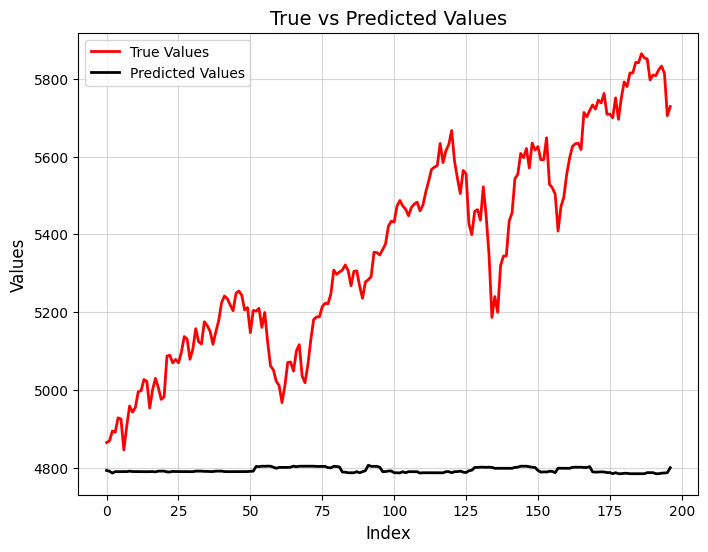

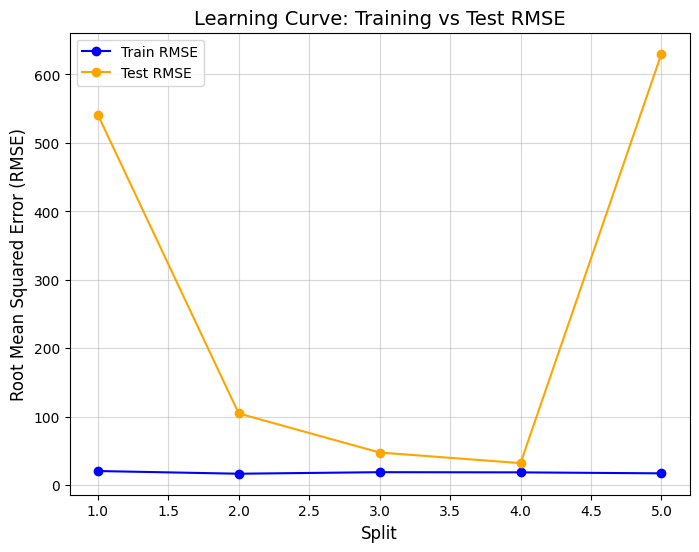

"plt.figure(figsize=(10, 6))\nplt.plot(range(1, len(train_rse) + 1), train_rse, marker='o', label='Train RSE', color='green')\nplt.plot(range(1, len(test_rse) + 1), test_rse, marker='o', label='Test RSE', color='purple')\nplt.title('Learning Curve: Training vs Test RSE', fontsize=14)\nplt.xlabel('Split', fontsize=12)\nplt.ylabel('Relative Standard Error (RSE)', fontsize=12)\nplt.legend()\nplt.grid(alpha=0.5)\nplt.show() "

In [ ]:
# Tracer les valeurs prédites et les valeurs vraies
plt.figure(figsize=(8, 6))
plt.plot(range(len(y_test)), y_test, label='True Values', color='red', linewidth=2)
plt.plot(range(len(y_test_pred)), y_test_pred, label='Predicted Values', color='black', linewidth=2)
plt.title('True vs Predicted Values', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


# Plot RMSE learning curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, marker='o', label='Train RMSE', color='blue')
plt.plot(range(1, len(rmse_list) + 1), rmse_list, marker='o', label='Test RMSE', color='orange')
plt.title('Learning Curve: Training vs Test RMSE', fontsize=14)
plt.xlabel('Split', fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Plot RSE learning curve
"""plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rse) + 1), train_rse, marker='o', label='Train RSE', color='green')
plt.plot(range(1, len(test_rse) + 1), test_rse, marker='o', label='Test RSE', color='purple')
plt.title('Learning Curve: Training vs Test RSE', fontsize=14)
plt.xlabel('Split', fontsize=12)
plt.ylabel('Relative Standard Error (RSE)', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show() """


### <u>- Conclusion Regression linéaire </u>
#### Métriques :
- **MAE** : 235 et **RMSE** : 270, indiquant des erreurs importantes par rapport à l'ordre de grandeur du S&P 500 (~5000-6000).
- **R²** : -0.94, montrant que le modèle ne capte pas la variance des données et est moins performant qu'une simple moyenne des valeurs.
- **Accuracy directionnelle** : 47%, moins bien que le hasard (50%).
Et le graphe de learning curve montre qu'il y a eu un surrentrainement extrême